# Lab 4 - Linear models

We focus on models in the form 

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

or in generalized form (generalized linear models)

$$ f(y) ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$

where $f(y)$ is a link function, for example - logit.


In [72]:
from cmdstanpy import CmdStanModel


import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

## Excercise 1 - modelling height of !Kung people

### Normal model - no predictors
We will try to fit $\mathrm{Normal}(\mu,\sigma)$ distribution to height data. Special case of linear model with $\beta=0$.

In [73]:
_BASE_URL = "https://raw.githubusercontent.com/rmcelreath/rethinking/Experimental/data"
HOWELL_DATASET_PATH = f"{_BASE_URL}/Howell1.csv"
d = pd.read_csv(HOWELL_DATASET_PATH, sep=';', header=0)
d=d[d.age>=18] #just adults 
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


In [74]:
model_ppc=CmdStanModel(stan_file='height_1_ppc.stan')

R = 1000
sim=model_ppc.sample(iter_sampling=R,
                     iter_warmup=0,
                     chains=1,
                     fixed_param=True,
                     seed=29042020,refresh=R)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


#### Task 1. Prior predictive checks

1. Plot histograms of mu, sigma and simulated height.
2. Plot a joint distribution of mu and sigma.
3. Check if samples are consistent with priors
4. Check if observed data is possible to obtain using priors.

In [75]:
sim.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0,0.00,0.0,0.0,NaN,NaN,NaN
mu,180.0,0.63,20,140.00,180.0,210.0,1000.0,100000.0,1.0
sigma,15.0,0.48,15,0.74,9.7,44.0,960.0,96000.0,1.0
height,180.0,0.99,31,130.00,180.0,230.0,950.0,95000.0,1.0


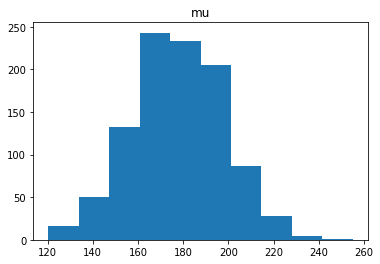

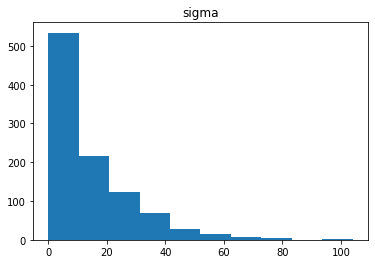

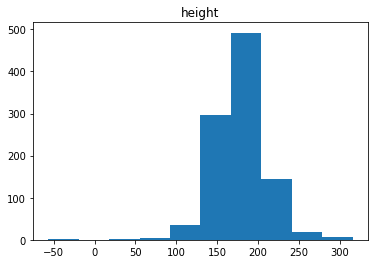

In [76]:
mu = sim.stan_variable("mu")
sigma = sim.stan_variable("sigma")
height = sim.stan_variable("height")
plt.hist(mu);
plt.title("mu")
plt.show()
plt.hist(sigma);
plt.title("sigma")
plt.show()
plt.hist(height);
plt.title("height")
plt.show()

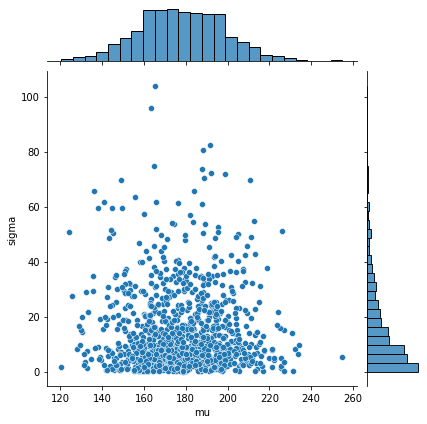

In [77]:
# plot a joint distribution of mu and sigma

import seaborn as sns
sim_df = sim.draws_pd()
sns.jointplot(data=sim_df, x="mu", y="sigma")

#### Task 2. Model fit and evaluation

1. Plot a joint distribution of fitted mu and sigma.
2. Plot histograms of data and simulated heights and evaluate the quality of model.



In [78]:
model_1_fit=CmdStanModel(stan_file='height_1_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [79]:
fit=model_1_fit.sample(data=dict(N=len(d),
                                   heights=d.height.values),
                         seed=28052020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


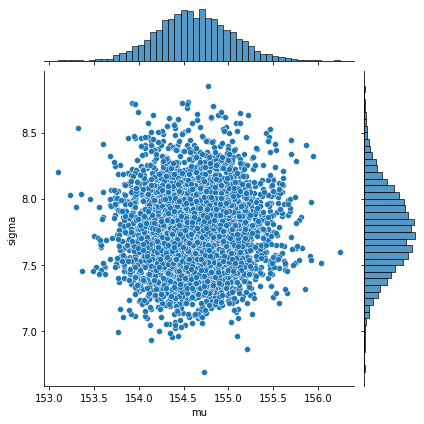

In [80]:
df_fit = fit.draws_pd()
sns.jointplot(data=df_fit, x="mu", y="sigma")

### Adding predictor to the model - weight

Create column ```c_weight``` in the dataframe containing weights substrated by their mean.


In [81]:
weight_mean = d['weight'].mean()
d['c_weight'] = d['weight'] / weight_mean
d

,height,weight,age,male,c_weight
0,151.765,47.825606,63.0,1,1.063016
1,139.700,36.485807,63.0,0,0.810967
2,136.525,31.864838,65.0,0,0.708257
3,156.845,53.041914,41.0,1,1.178958
4,145.415,41.276872,51.0,0,0.917458
...,...,...,...,...,...
534,162.560,47.031821,27.0,0,1.045373
537,142.875,34.246196,31.0,0,0.761188
540,162.560,52.163080,31.0,1,1.159425
541,156.210,54.062497,21.0,0,1.201643


In [82]:
model_ppc=CmdStanModel(stan_file='height_2a_ppc.stan')
R = 1000
data_sim={'N':50, 'weight':np.linspace(d.c_weight.min(),d.c_weight.max())}
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


#### Task 4. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.

In [83]:
sim_df = sim.draws_pd()

alpha = list(sim_df.alpha)
beta = list(sim_df.beta)

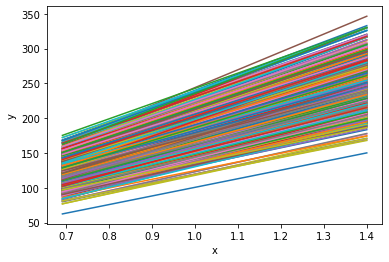

In [84]:
for alpha_, beta_ in zip(alpha, beta):
    x = np.linspace(d["c_weight"].min(), d["c_weight"].max(), 1000)
    y = alpha_*x + beta_
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("y")

### Modifying prior

If prior for beta admits negative values, then it makes no sense. Lets change prior to lognormal distribution.


In [85]:
model_ppc=CmdStanModel(stan_file='height_2b_ppc.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [86]:
sim=model_ppc.sample(data=data_sim, 
                     iter_sampling=R, 
                     iter_warmup=0, 
                     chains=1, 
                     refresh=R,
                     fixed_param=True,
                     seed=29042020)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


#### Task 5. Prior predictive checks
1. Plot lines for each sampled slope beta and intercept alpha, verify if possible predicted heights are consistent with minimum (0) and maximum (check Wikipedia) heights observed in nature.
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data. Is observed data possible within the prior model?

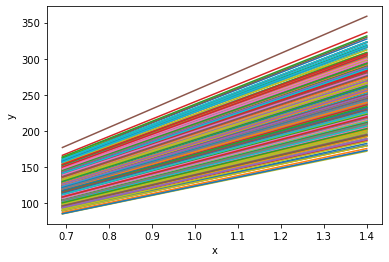

In [87]:
sim_df = sim.draws_pd()

alpha = list(sim_df.alpha)
beta = list(sim_df.beta)

for alpha_, beta_ in zip(alpha, beta):
    x = np.linspace(d["c_weight"].min(), d["c_weight"].max(), 1000)
    y = alpha_*x + beta_
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("y")

<AxesSubplot:xlabel='weight', ylabel='Density'>

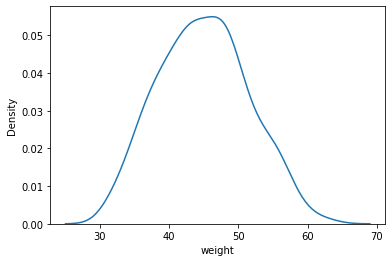

In [88]:
sns.kdeplot(d["weight"])

In [89]:
d["weight"].describe()

count    352.000000
mean      44.990486
std        6.456708
min       31.071052
25%       40.256290
50%       44.792210
75%       49.292693
max       62.992589
Name: weight, dtype: float64

In [90]:
sim_df.describe()

,lp__,accept_stat__,alpha,beta,sigma,height[1],height[2],height[3],height[4],height[5],...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
count,1000.0,1000.0,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.0,0.0,178.073435,1.697292,14.729969,178.793422,179.611691,178.837462,179.966477,178.990186,...,180.054408,179.368806,179.499303,180.288116,180.136514,180.63539,180.395705,180.034950,179.945865,179.769050
std,0.0,0.0,20.113798,2.280632,14.509960,29.042097,30.758925,27.545909,30.195444,29.212537,...,28.823513,29.275205,29.126004,29.506864,28.272113,30.67404,29.740388,28.348453,28.166499,28.959025
min,0.0,0.0,121.392000,0.030154,0.003578,-23.798800,38.649400,19.638700,40.698100,36.558500,...,5.105650,38.438800,37.547300,24.669600,68.727800,49.61450,62.202100,39.380100,71.046600,52.843900
25%,0.0,0.0,164.314500,0.543203,4.240158,161.892500,162.477250,163.269750,161.130000,161.684750,...,162.802500,161.264500,162.426250,163.468000,162.851500,162.54075,162.790000,163.591000,162.982250,163.185500
50%,0.0,0.0,177.804000,0.962892,10.131550,177.812000,179.294000,178.525000,179.651000,178.010500,...,178.901500,178.489500,178.112500,178.946500,180.033500,179.50700,179.936500,180.389000,179.585500,179.187000
75%,0.0,0.0,191.444000,2.049410,20.386800,194.875250,196.084500,196.073500,197.415000,196.070250,...,197.288250,197.013500,196.465000,197.238000,196.789000,198.12825,197.176750,197.169250,197.002250,197.061250
max,0.0,0.0,255.971000,26.580300,90.768200,352.277000,339.971000,309.370000,335.679000,329.081000,...,312.177000,302.903000,461.934000,344.523000,336.332000,358.38600,365.633000,336.779000,299.848000,365.510000


In [91]:
sim.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.0,NaN,0.0,0.00,0.00,0.0,NaN,NaN,NaN
alpha,180.0,0.640,20.0,150.00,180.00,210.0,990.0,15000.0,1.0
beta,1.7,0.078,2.3,0.19,0.96,5.5,850.0,13000.0,1.0
sigma,15.0,0.450,15.0,0.72,10.00,45.0,1100.0,16000.0,1.0
height[1],179.0,0.920,29.0,136.00,178.00,224.0,990.0,14566.0,1.0
height[2],180.0,0.990,31.0,133.00,179.00,225.0,968.0,14243.0,1.0
height[3],179.0,0.900,28.0,135.00,179.00,220.0,941.0,13842.0,1.0
height[4],180.0,0.960,30.0,135.00,180.00,225.0,989.0,14545.0,1.0
height[5],179.0,0.960,29.0,133.00,178.00,225.0,929.0,13656.0,1.0


In [92]:
height_min = sim_df.describe().loc['min']['height[1]':'height[50]']
height_max = sim_df.describe().loc['max']['height[1]':'height[50]']
height_25 = sim_df.describe().loc['25%']['height[1]':'height[50]']
height_50 = sim_df.describe().loc['25%']['height[1]':'height[50]']
height_75 = sim_df.describe().loc['25%']['height[1]':'height[50]']
height_5 = sim.summary()['5%'].loc['height[1]':'height[50]']
height_95 = sim.summary()['95%'].loc['height[1]':'height[50]']

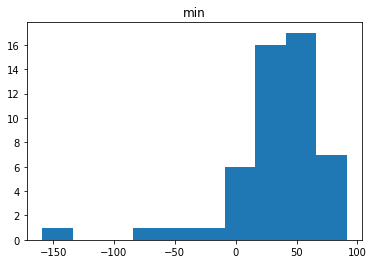

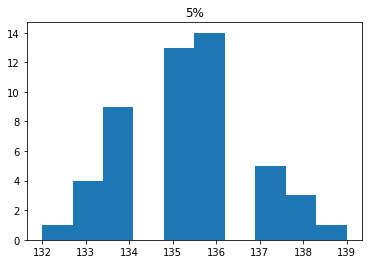

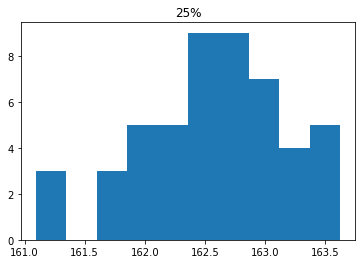

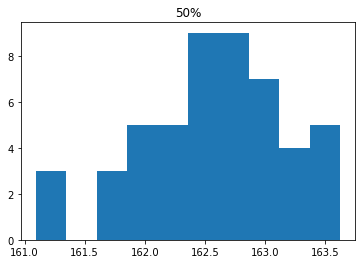

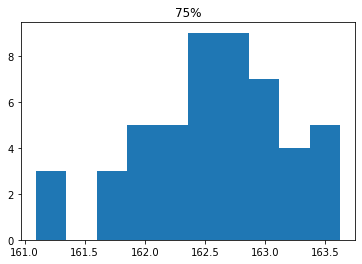

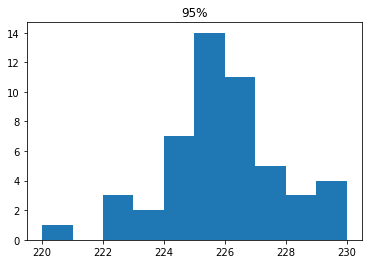

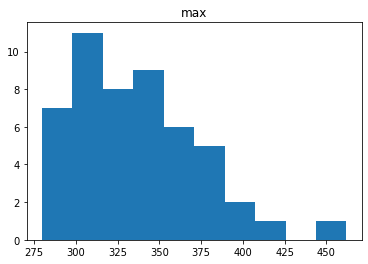

In [93]:
values = [height_min, height_5, height_25, height_50, height_75, height_95, height_max]
titles = ["min", "5%", "25%", "50%", "75%", "95%", "max"]
for value, title in zip(values, titles):
    plt.hist(value)
    plt.title(title)
    plt.show()

### Fitting data


In [94]:
model_2_fit=CmdStanModel(stan_file='height_2_fit.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


#### Task 6. Preparing data for fit
1. Create ```data_fit``` dictionary containing data from  ```N``` first rows of dataframe

In [95]:
N = 50
data_fit = {"N": N, "weight": list(d['weight'])[:N], "heights": list(d['height'])[:N]}
fit=model_2_fit.sample(data=data_fit,seed=28052020)


INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |▍         | 00:00 Status



chain 1 |███▋      | 00:00 Iteration:  600 / 2000 [ 30%]  (Warmup)

chain 1 |██████▎   | 00:00 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


#### Task 7. Evaluating model

1. Plot lines for each sampled slope beta and intercept alpha. Verify how uncertainity changes with increasing of sample (N)
2. For each simulated weight plot maximum, minimum, and 5, 25, 50, 75, 95 quantiles of simulated weight (all in the same plot). Compare with observed data (N points). Is observed data possible within the posterior model? What changes when N increases.


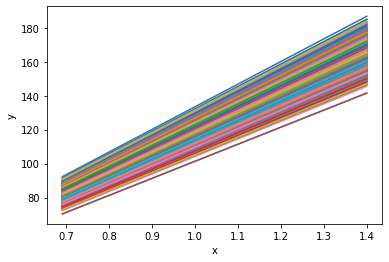

In [96]:
df_fit = fit.draws_pd()

alpha = list(df_fit.alpha)
beta = list(df_fit.beta)

for alpha_, beta_ in zip(alpha, beta):
    x = np.linspace(d["c_weight"].min(), d["c_weight"].max(), 1000)
    y = alpha_*x + beta_
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("y")

In [97]:
df_fit.describe()

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,height[41],height[42],height[43],height[44],height[45],height[46],height[47],height[48],height[49],height[50]
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-109.638683,0.931027,0.116986,3.809750,22.41050,0.0,111.134386,116.527686,0.809983,5.062563,...,152.840283,164.035138,154.293453,152.413611,157.805409,160.493119,153.667918,155.480558,158.702464,155.031467
std,1.260610,0.101677,0.008416,1.150602,13.62791,0.0,1.764292,4.504171,0.098886,0.541138,...,5.171742,5.267226,5.283173,5.074015,5.234223,5.225206,5.178961,5.111337,5.210859,5.000006
min,-117.198000,0.100693,0.104787,1.000000,1.00000,0.0,108.187000,100.224000,0.434536,3.589330,...,129.259000,142.984000,136.056000,134.054000,138.194000,141.167000,130.409000,135.152000,139.288000,136.296000
25%,-110.194250,0.907877,0.112052,3.000000,11.00000,0.0,109.852750,113.593250,0.744123,4.680575,...,149.330000,160.648250,150.905000,149.124750,154.366000,157.060750,150.166000,151.906000,155.295000,151.638750
50%,-109.318000,0.973803,0.117831,4.000000,23.00000,0.0,110.785500,116.460500,0.810771,5.006250,...,152.825500,164.110000,154.259000,152.483000,157.892500,160.614500,153.657500,155.447500,158.752000,155.131500
75%,-108.715750,0.996070,0.122765,5.000000,31.00000,0.0,112.101500,119.530250,0.875738,5.394750,...,156.290000,167.577000,157.829500,155.741750,161.283500,163.969250,157.074250,158.856250,162.165000,158.449500
max,-108.091000,1.000000,0.127495,6.000000,63.00000,0.0,124.478000,133.083000,1.175870,7.674460,...,173.910000,184.272000,173.644000,172.554000,180.051000,185.268000,176.463000,187.672000,177.262000,171.666000


In [98]:
fit.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-110.00,0.0370,1.300,-110.00,-110.00,-110.00,1200.0,740.0,1.0
alpha,120.00,0.1400,4.500,110.00,120.00,120.00,1100.0,660.0,1.0
beta,0.81,0.0031,0.099,0.64,0.81,0.97,1000.0,650.0,1.0
sigma,5.10,0.0140,0.540,4.30,5.00,6.00,1500.0,970.0,1.0
mu[1],155.00,0.0130,0.770,154.00,155.00,157.00,3623.0,2280.0,1.0
...,...,...,...,...,...,...,...,...,...
height[46],160.00,0.0840,5.200,152.00,161.00,169.00,3829.0,2410.0,1.0
height[47],154.00,0.0800,5.200,145.00,154.00,162.00,4213.0,2651.0,1.0
height[48],155.00,0.0810,5.100,147.00,155.00,164.00,4027.0,2534.0,1.0


In [99]:
height_min = df_fit.describe().loc['min']['height[1]':'height[50]']
height_max = df_fit.describe().loc['max']['height[1]':'height[50]']
height_25 = df_fit.describe().loc['25%']['height[1]':'height[50]']
height_50 = df_fit.describe().loc['25%']['height[1]':'height[50]']
height_75 = df_fit.describe().loc['25%']['height[1]':'height[50]']
height_5 = fit.summary()['5%'].loc['height[1]':'height[50]']
height_95 = fit.summary()['95%'].loc['height[1]':'height[50]']

In [100]:
height_min.head()

height[1]    129.020
height[2]    125.634
height[3]    122.769
height[4]    137.752
height[5]    126.562
Name: min, dtype: float64

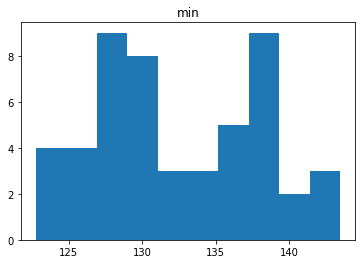

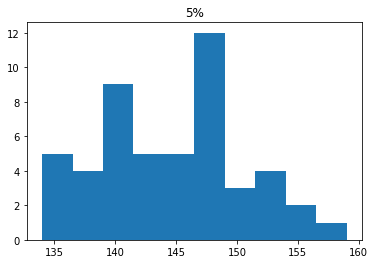

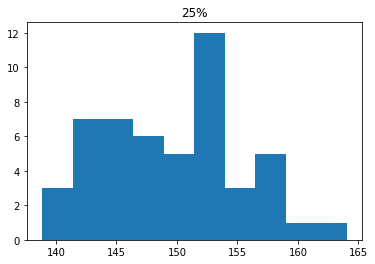

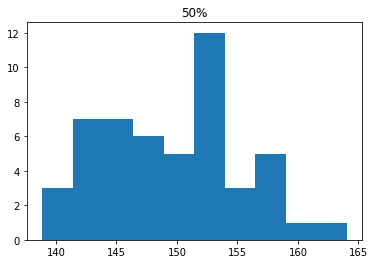

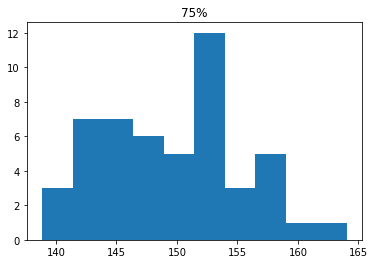

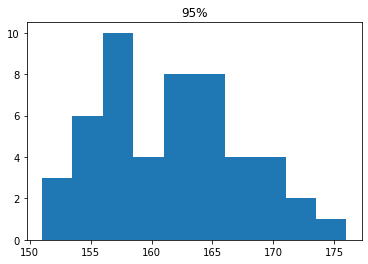

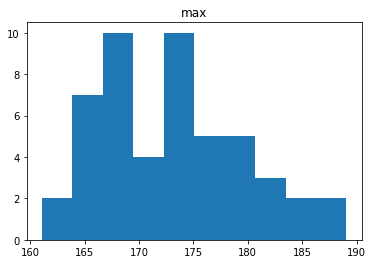

In [101]:
values = [height_min, height_5, height_25, height_50, height_75, height_95, height_max]
titles = ["min", "5%", "25%", "50%", "75%", "95%", "max"]
for value, title in zip(values, titles):
    plt.hist(value)
    plt.title(title)
    plt.show()